# Feature Engineering

In [1]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option("display.max_columns", None)

In [2]:
SRC_PATH = Path.joinpath(Path.cwd().parent, 'src')
DATA_PATH = Path.joinpath(Path.cwd().parent, 'data')
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [3]:
target_varname = "SalePrice"
target = train[target_varname]
train.drop([target_varname, 'Id'], axis=1, inplace=True)

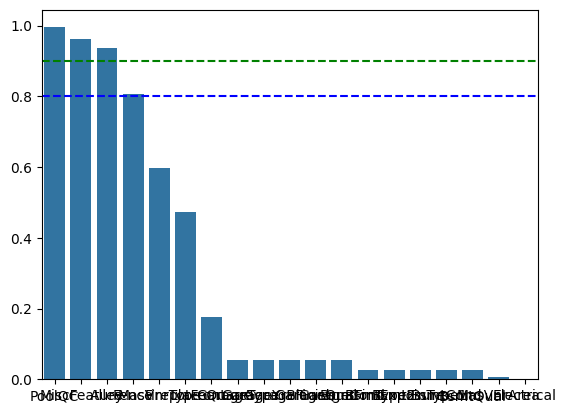

In [4]:
# missing data proportions as example of some analysis to do
na_vars = train.columns[train.isnull().sum()>0]
sns.barplot(
    data=train[na_vars].isnull().mean().sort_values(ascending=False),
)
plt.axhline(y=0.90, c='g', linestyle='--')
plt.axhline(y=0.80, c='b', linestyle='--')
plt.show()

# Feature Engineering
Steps to take:</br>
1. Missing values
2. Temporal variables
3. Non-gaussian distributed variables
4. Categorical vars: Remove rare labels
5. Categorical vars: convert string to numbers (for ordinals)
6. Standardize values to the same range

In [5]:
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib

In [6]:
# set seed for reproducibility
SEED = 20240626

In [7]:
# split data
X_train, X_test, y_train, y_test = train_test_split(
    train,
    target,
    test_size=0.1,
    random_state=SEED
)
print(X_train.shape, X_test.shape)

(1314, 79) (146, 79)


In [8]:
# log target
y_train = np.log(y_train)
y_test = np.log(y_test)

## 1. Missing values

In [9]:
cat_vars = train.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()
# add MSSubClass as well as documentation states that it is a categorical as well
cat_vars = cat_vars + ["MSSubClass"]
# cast categorical variables
X_train[cat_vars] = X_train[cat_vars].astype("O")
X_test[cat_vars] = X_test[cat_vars].astype("O")
print(len(cat_vars))

44


In [10]:
# perform this on train so guarantee reproducibility
# impute missing values for catr cols with missing values > 10% of data with str='missing'
with_str_missing = [
    var for var in cat_vars if X_train[var].isnull().mean() > 0.1
]
# otherwise impute with most frequent
with_freq_category = [
    var for var in cat_vars if X_train[var].isnull().mean() <= 0.1
]
print(with_str_missing)

['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [11]:
# now replace missing values
X_train[with_str_missing] = X_train[with_str_missing].fillna(value='Missing')
X_test[with_str_missing] = X_test[with_str_missing].fillna(value='Missing')

In [12]:
# now replacing values with mode
for var in with_freq_category:
    mode = X_train[var].mode()[0]
    print(var, mode)
    X_train[var] = X_train[var].fillna(value=mode)
    X_test[var] = X_test[var].fillna(value=mode)

MSZoning RL
Street Pave
LotShape Reg
LandContour Lvl
Utilities AllPub
LotConfig Inside
LandSlope Gtl
Neighborhood NAmes
Condition1 Norm
Condition2 Norm
BldgType 1Fam
HouseStyle 1Story
RoofStyle Gable
RoofMatl CompShg
Exterior1st VinylSd
Exterior2nd VinylSd
ExterQual TA
ExterCond TA
Foundation PConc
BsmtQual TA
BsmtCond TA
BsmtExposure No
BsmtFinType1 Unf
BsmtFinType2 Unf
Heating GasA
HeatingQC Ex
CentralAir Y
Electrical SBrkr
KitchenQual TA
Functional Typ
GarageType Attchd
GarageFinish Unf
GarageQual TA
GarageCond TA
PavedDrive Y
SaleType WD
SaleCondition Normal
MSSubClass 20


/var/folders/5f/7_2jkfbj58x6cf8373dprpfw0000gn/T/ipykernel_37410/3934405011.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train[var] = X_train[var].fillna(value=mode)
/var/folders/5f/7_2jkfbj58x6cf8373dprpfw0000gn/T/ipykernel_37410/3934405011.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test[var] = X_test[var].fillna(value=mode)


In [13]:
# for numerical variables
num_vars = train.select_dtypes(include=['int', 'float']).columns.tolist()
# get num vars with missing values
num_vars_na = [var for var in num_vars if X_train[var].isnull().sum()>0]

In [14]:
# 1. create and indicator when value is missing
# 2. impute with mean
for var in num_vars_na:
    mean = X_train[var].mean()
    print(var, mean)
    # add binary column
    X_train[var+'_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var+'_na'] = np.where(X_test[var].isnull(), 1, 0)
    # replace missing values with mean
    X_train[var] = X_train[var].fillna(value=mean)
    X_test[var] = X_test[var].fillna(value=mean)

LotFrontage 69.82806691449814
MasVnrArea 102.29862174578867
GarageYrBlt 1978.4826752618856


## Temporal variables

In [15]:
def elapsed_time(df, elapse_var, var):
    df[var] = df[elapse_var] - df[var]
    return df

In [16]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_time(X_train, 'YrSold', var)
    X_test = elapsed_time(X_test, 'YrSold', var)

In [17]:
# now drop elapse_var
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

## Log transforms

In [18]:
# for variables with only positive values
for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
    X_train[var] = np.log(X_train[var])
    X_test[var] = np.log(X_test[var])

In [19]:
X_train["LotArea"], param = stats.yeojohnson(X_train["LotArea"])
X_test["LotArea"] = stats.yeojohnson(X_test["LotArea"], lmbda=param)

## binarize skewed variables

In [20]:
skewed = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]
for var in skewed:
    X_train[var] = np.where(X_train[var]==0, 0, 1)
    X_test[var] = np.where(X_test[var]==0, 0, 1)

## Apply mappings (for ordinals)

In [21]:
X_train.FireplaceQu.isnull().sum()

np.int64(0)

In [22]:
qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

qual_vars = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
    'HeatingQC', 'KitchenQual', 'FireplaceQu',
    'GarageQual', 'GarageCond',
]

for var in qual_vars:
    X_train[var] = X_train[var].map(qual_mappings)
    X_test[var] = X_test[var].map(qual_mappings)

In [23]:
exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

var = 'BsmtExposure'

X_train[var] = X_train[var].map(exposure_mappings)
X_test[var] = X_test[var].map(exposure_mappings)

In [24]:
finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

finish_vars = ['BsmtFinType1', 'BsmtFinType2']

for var in finish_vars:
    X_train[var] = X_train[var].map(finish_mappings)
    X_test[var] = X_test[var].map(finish_mappings)

In [25]:
garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

var = 'GarageFinish'

X_train[var] = X_train[var].map(garage_mappings)
X_test[var] = X_test[var].map(garage_mappings)

In [26]:
fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

var = 'Fence'

X_train[var] = X_train[var].map(fence_mappings)
X_test[var] = X_test[var].map(fence_mappings)

In [27]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

## Remove rare labels

In [28]:
qual_vars  = qual_vars + finish_vars + ['BsmtExposure','GarageFinish','Fence']
cat_others = [
    var for var in cat_vars if var not in qual_vars
]
len(cat_others)

30

In [29]:
def find_frequent_labels(df, var, rare_perc):
    df = df.copy()
    tmp = df.groupby(var)[var].count() / len(df)

    return tmp[tmp > rare_perc].index

In [30]:
for var in cat_others:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.01)
    
    print(var, frequent_ls)
    print()
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(
        X_train[var].isin(frequent_ls),
        X_train[var], 
        'Rare'
    )
    
    X_test[var] = np.where(
        X_test[var].isin(frequent_ls),
        X_test[var],
        'Rare'
    )

MSZoning Index(['FV', 'RH', 'RL', 'RM'], dtype='object', name='MSZoning')

Street Index(['Pave'], dtype='object', name='Street')

Alley Index(['Grvl', 'Missing', 'Pave'], dtype='object', name='Alley')

LotShape Index(['IR1', 'IR2', 'Reg'], dtype='object', name='LotShape')

LandContour Index(['Bnk', 'HLS', 'Low', 'Lvl'], dtype='object', name='LandContour')

Utilities Index(['AllPub'], dtype='object', name='Utilities')

LotConfig Index(['Corner', 'CulDSac', 'FR2', 'Inside'], dtype='object', name='LotConfig')

LandSlope Index(['Gtl', 'Mod'], dtype='object', name='LandSlope')

Neighborhood Index(['Blmngtn', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor',
       'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NWAmes',
       'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW',
       'Somerst', 'StoneBr', 'Timber'],
      dtype='object', name='Neighborhood')

Condition1 Index(['Artery', 'Feedr', 'Norm', 'PosN', 'RRAn'], dtype='object', name='Condition1')

Con

## Encoding categorical variables

In [31]:
def replace_categories(train, test, y_train, var, target):
    
    tmp = pd.concat([X_train, y_train], axis=1)
    
    # order the categories in a variable from that with the lowest
    # house sale price, to that with the highest
    ordered_labels = tmp.groupby([var])[target].mean().sort_values().index

    # create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}
    
    print(var, ordinal_label)
    print()

    # use the dictionary to replace the categorical strings by integers
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)

In [32]:
for var in cat_others:
    replace_categories(X_train, X_test, y_train, var, target_varname)

MSZoning {'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4}

Street {'Rare': 0, 'Pave': 1}

Alley {'Grvl': 0, 'Pave': 1, 'Missing': 2}

LotShape {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3}

LandContour {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3}

Utilities {'Rare': 0, 'AllPub': 1}

LotConfig {'Inside': 0, 'FR2': 1, 'Corner': 2, 'CulDSac': 3, 'Rare': 4}

LandSlope {'Gtl': 0, 'Mod': 1, 'Rare': 2}

Neighborhood {'IDOTRR': 0, 'MeadowV': 1, 'BrDale': 2, 'BrkSide': 3, 'Edwards': 4, 'OldTown': 5, 'Sawyer': 6, 'SWISU': 7, 'NAmes': 8, 'Mitchel': 9, 'Rare': 10, 'SawyerW': 11, 'NWAmes': 12, 'Gilbert': 13, 'Blmngtn': 14, 'CollgCr': 15, 'Crawfor': 16, 'ClearCr': 17, 'Somerst': 18, 'Timber': 19, 'StoneBr': 20, 'NridgHt': 21, 'NoRidge': 22}

Condition1 {'Artery': 0, 'Feedr': 1, 'Norm': 2, 'RRAn': 3, 'Rare': 4, 'PosN': 5}

Condition2 {'Rare': 0, 'Norm': 1}

BldgType {'2fmCon': 0, 'Twnhs': 1, 'Duplex': 2, '1Fam': 3, 'TwnhsE': 4}

HouseStyle {'SFoyer': 0, '1.5Fin': 1, 'Rare': 2, '1Story': 3, 'SLvl': 4, '2Story'

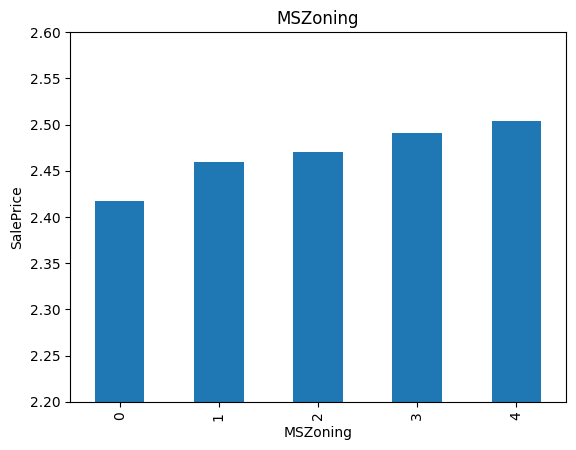

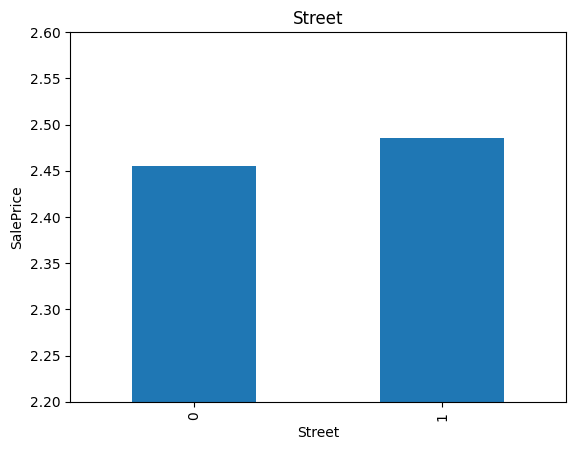

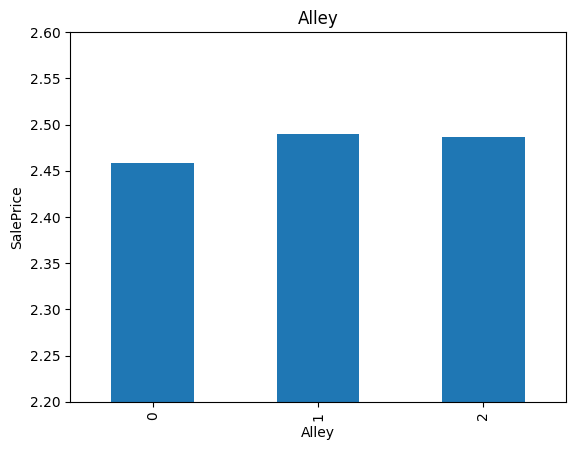

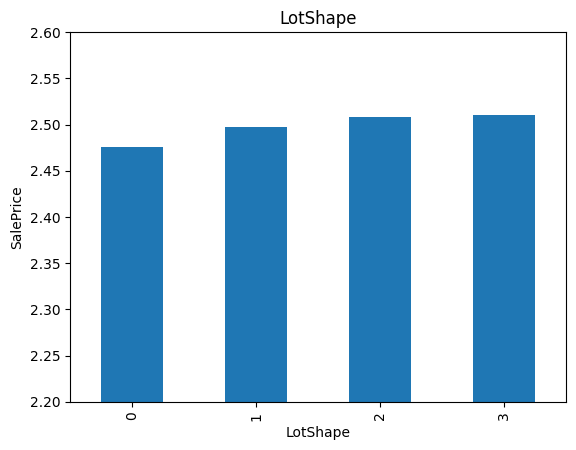

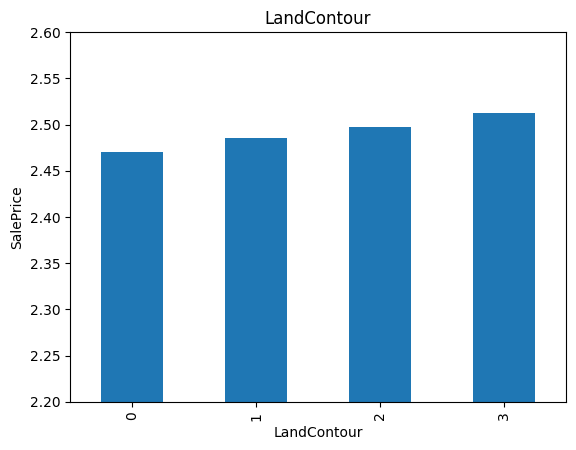

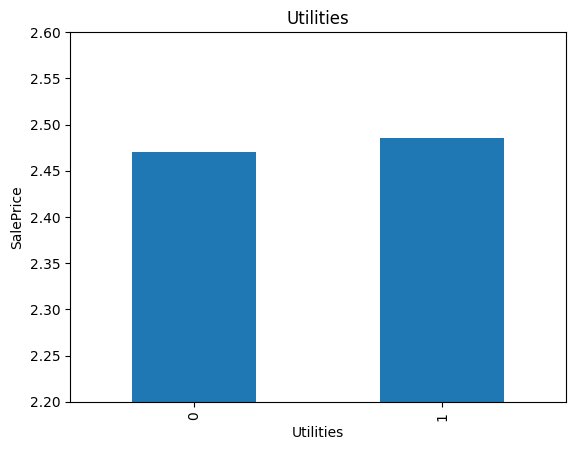

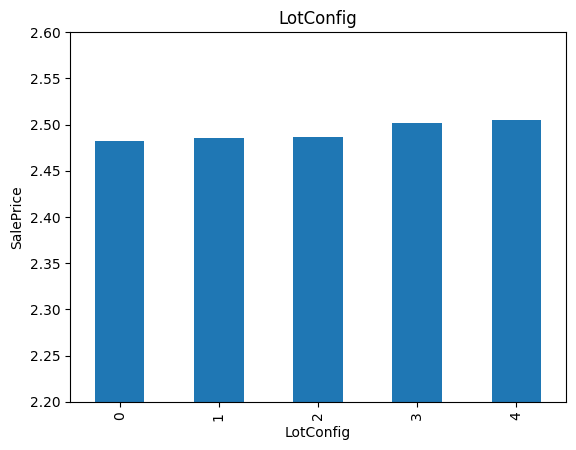

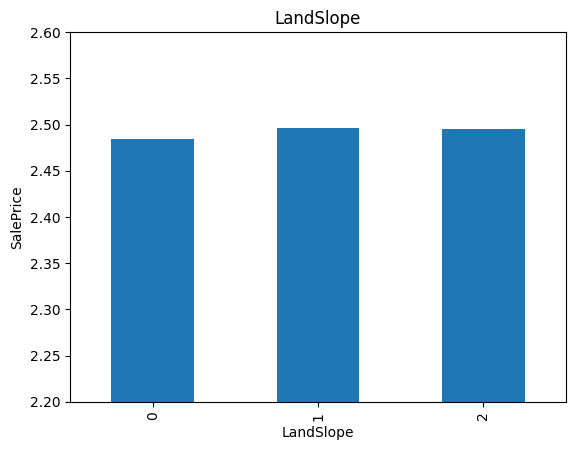

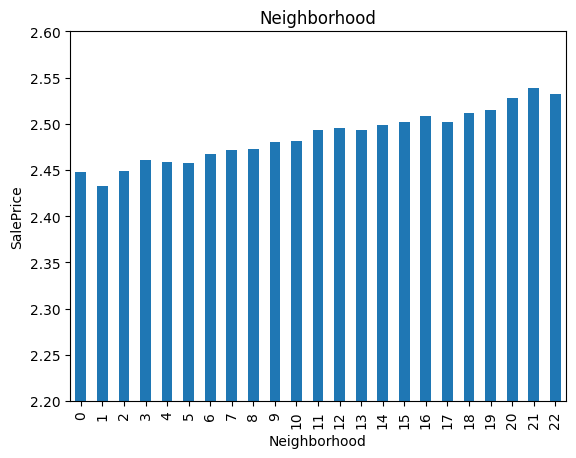

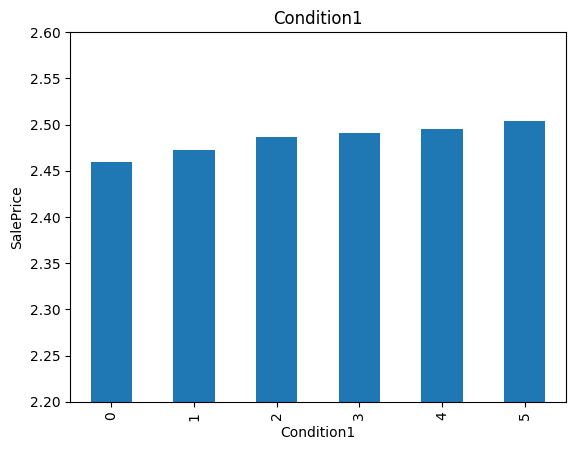

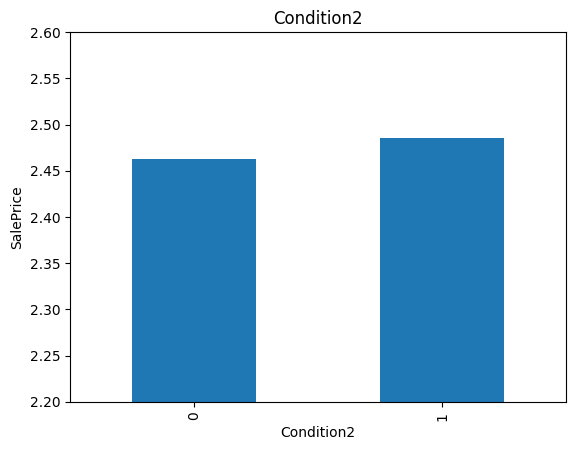

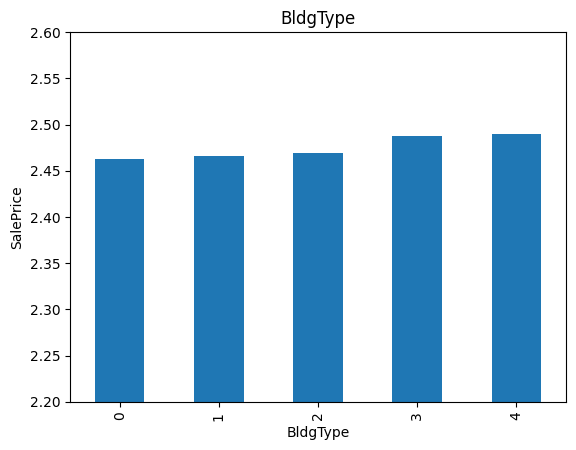

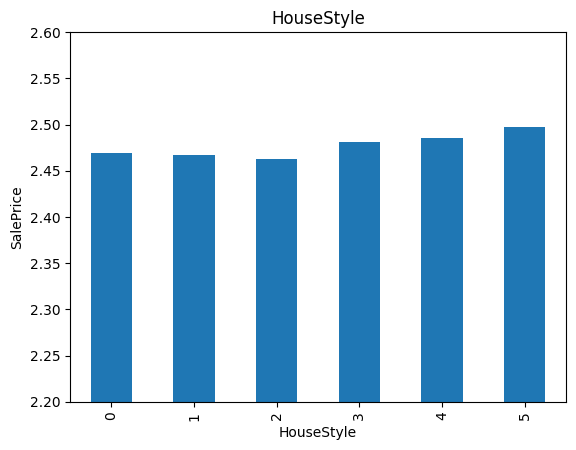

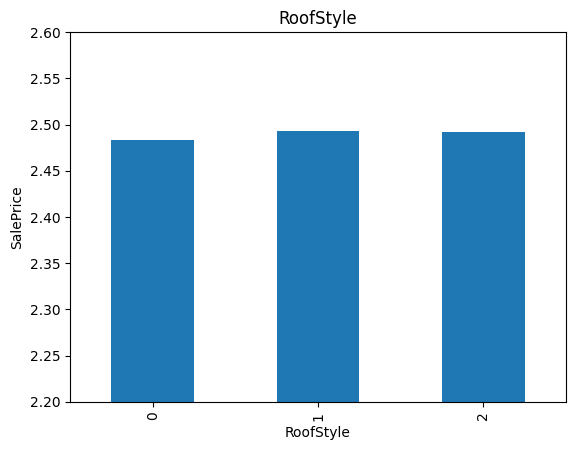

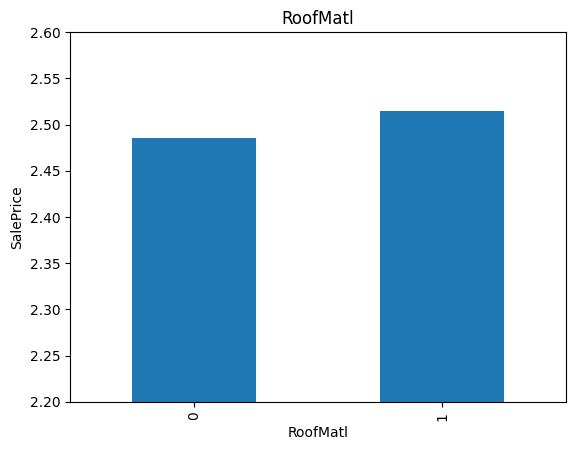

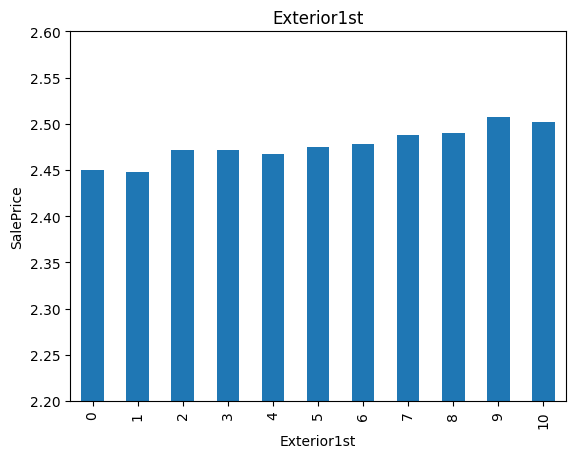

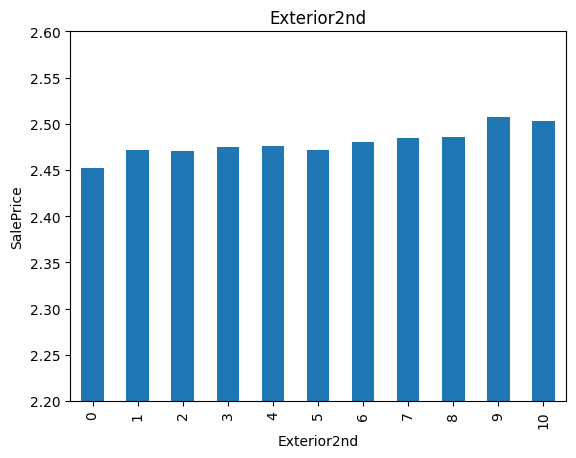

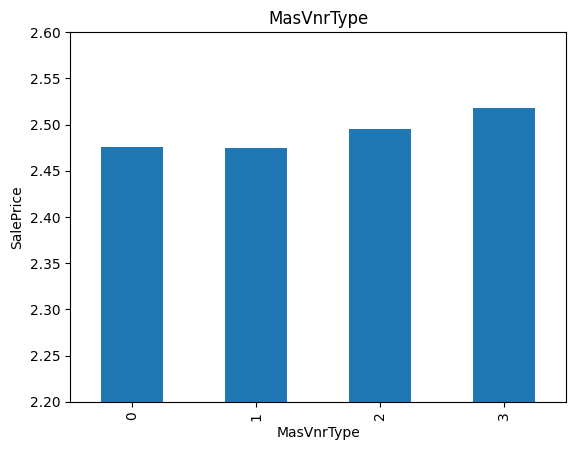

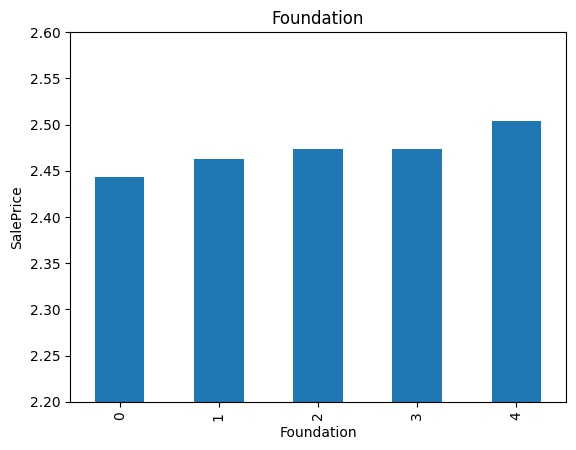

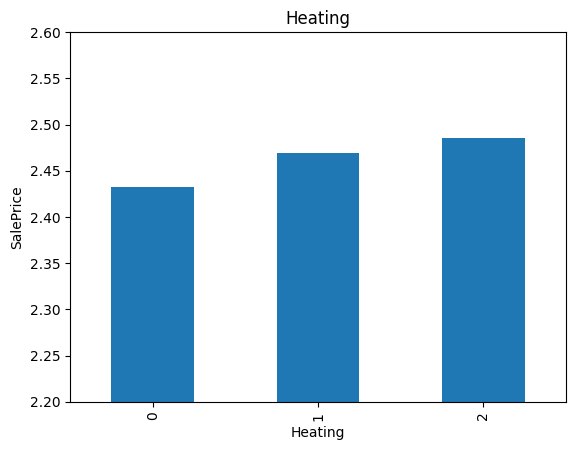

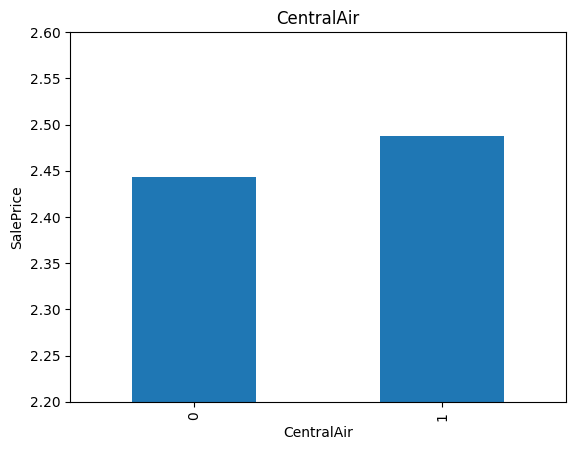

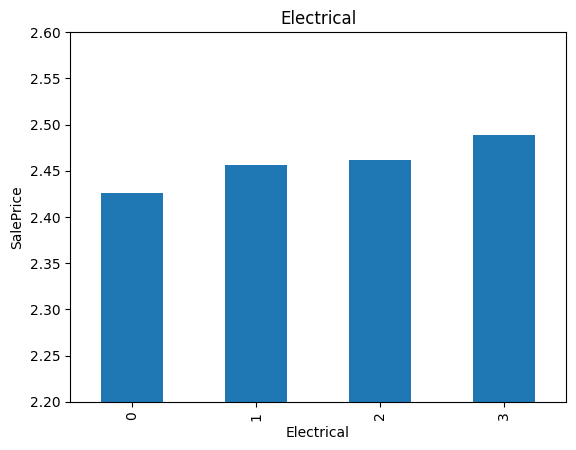

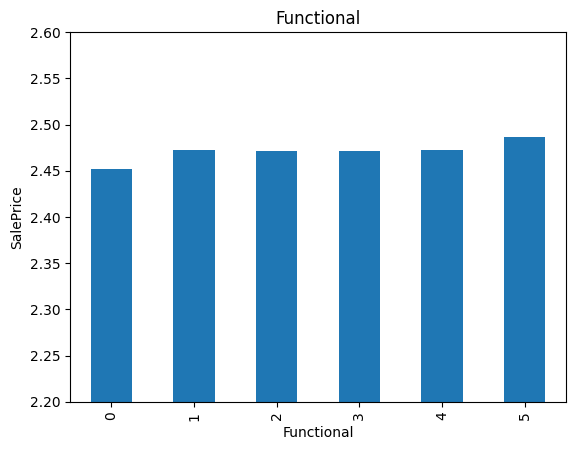

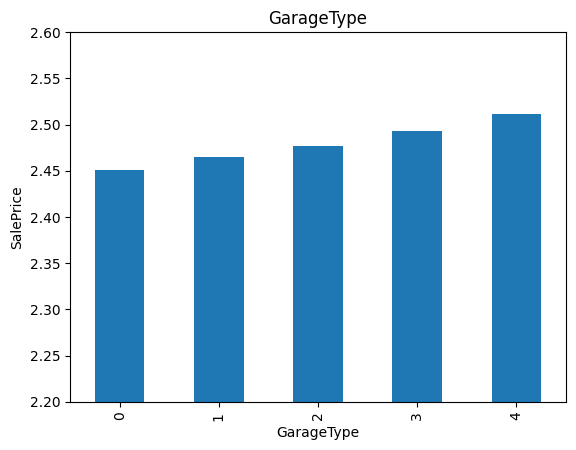

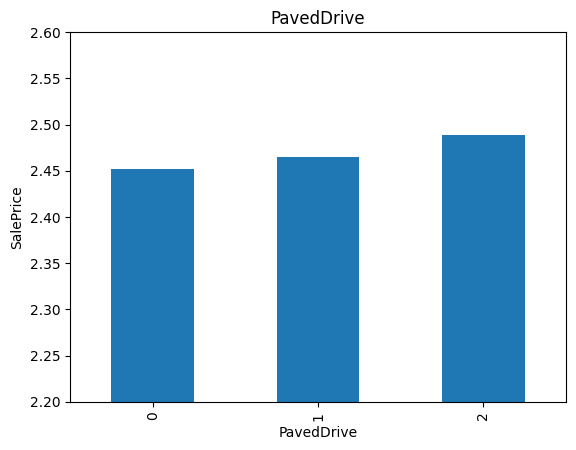

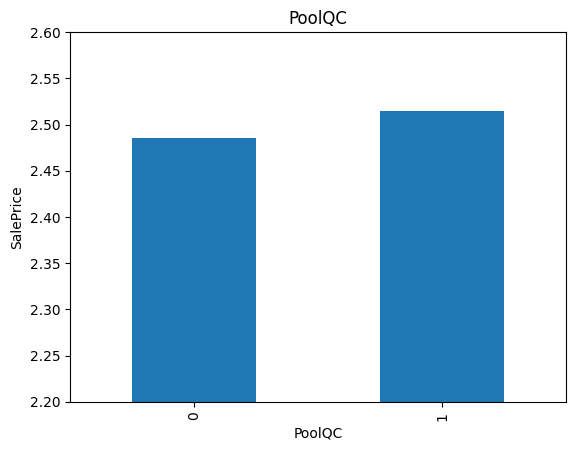

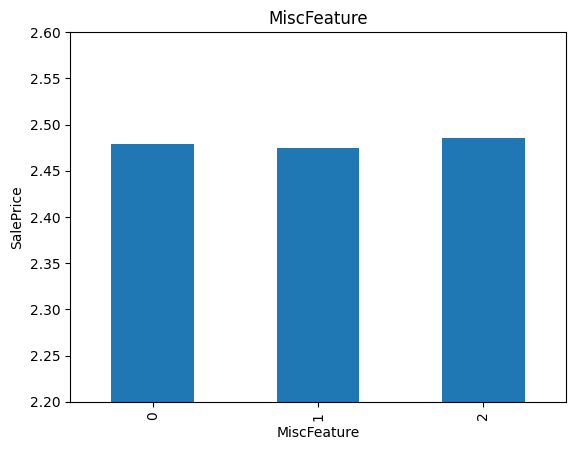

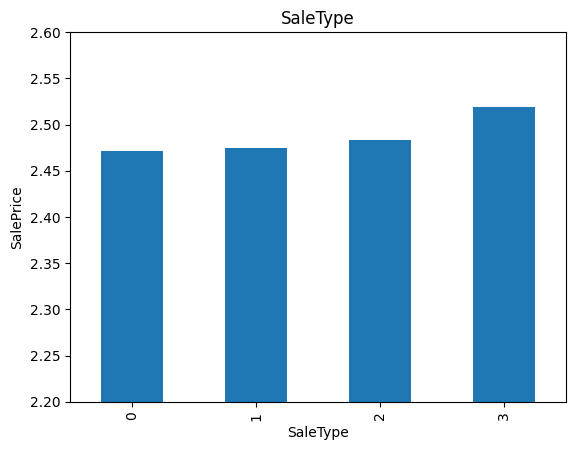

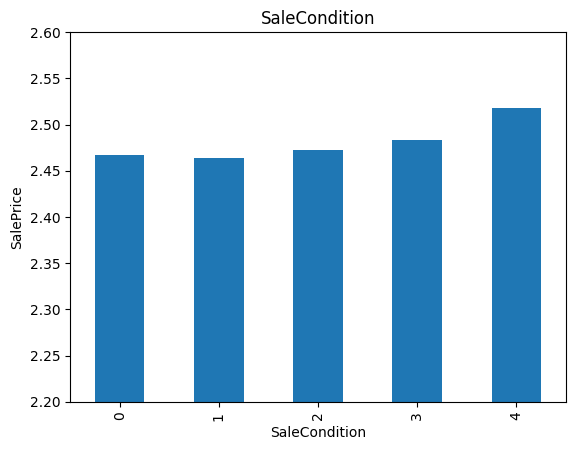

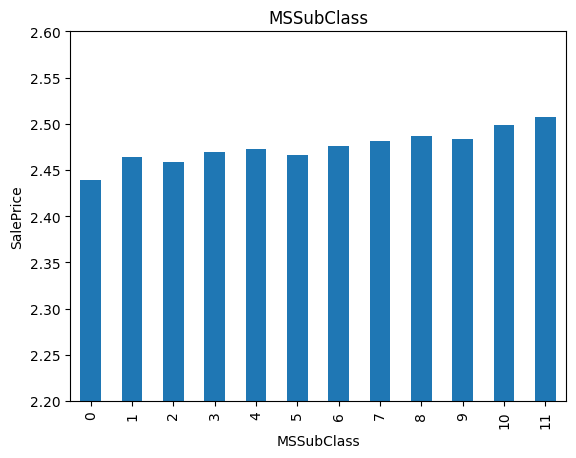

In [33]:
# check the monotonic relations between the encodings and the sales price.
# the main goal behind the previous transformation was to make sure the ordinal
# values got a relation with the target.
def analyse_vars(train, y_train, var, target_varname):
    
    # function plots median house sale price per encoded
    # category
    
    tmp = pd.concat([X_train, np.log(y_train)], axis=1)
    
    tmp.groupby(var)[target_varname].median().plot.bar()
    plt.title(var)
    plt.ylim(2.2, 2.6)
    plt.ylabel(target_varname)
    plt.show()
    
for var in cat_others:
    analyse_vars(X_train, y_train, var, target_varname)

## Feature scaling

In [34]:
# create scaler
scaler = MinMaxScaler()
#  fit  the scaler to the train set
scaler.fit(X_train) 

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)

X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_train.columns
)

# Save transformed data and objects

In [35]:
# transformed data
X_train.to_csv(str(DATA_PATH)+'/data_model/xtrain.csv', index=False)
X_test.to_csv(str(DATA_PATH)+'/data_model/xtest.csv', index=False)

y_train.to_csv(str(DATA_PATH)+'/data_model/ytrain.csv', index=False)
y_test.to_csv(str(DATA_PATH)+'/data_model/ytest.csv', index=False)

# preprocessor
joblib.dump(scaler, str(SRC_PATH)+'/minmax_scaler.joblib')

['/Users/juandiegogallegoquiceno/Desktop/PersonalProjects/mlops/deployment-ml-models/src/minmax_scaler.joblib']